In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, ifft2, fftshift
from tqdm import tqdm

# Set random seed for reproducibility
np.random.seed(1)

def plot_field_2d(data, title, cmap='viridis'):
    """
    Helper function to plot 2D fields.
    """
    plt.figure(figsize=(6, 5))
    plt.imshow(data, cmap=cmap, origin='lower')
    plt.colorbar(label='u(x, y)')
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

def get_power_spectrum_2d(data):
    """
    Computes the azimuthally averaged power spectrum.
    Useful for checking if generative models capture the correct frequency content.
    """
    F = fftshift(fft2(data))
    psd = np.abs(F)**2
    return psd

## Stochastic Allen-Cahn Equation (2D SPDE)
**Mathematical Form:**
$$ \frac{\partial u}{\partial t} = D \nabla^2 u - \frac{1}{\epsilon^2} u (u^2 - 1) + \sigma \xi(x, t) $$

where $\xi(x, t)$ is space-time white noise.

**Characteristics:**

This stochastic PDE describes phase separation with thermal fluctuations. The solution $u$ tends towards $+1$ or $-1$, forming "grains" separated by interfaces that fluctuate due to noise.*   **Target for GenAI:** Can the model capture both sharp interfaces AND stochastic fluctuations?
*   **Noise term:** $\sigma$ controls the noise intensity. Larger $\sigma$ leads to more interface roughening.

Simulating Stochastic Allen-Cahn (SPDE) for 300 steps...
  Noise intensity: sigma = 1.4142
  Epsilon: 0.02


100%|██████████| 300/300 [00:00<00:00, 3048.13it/s]


Numerical check:
  Step 0: min=-0.5000, max=0.4999, has_nan=False, has_inf=False
  Step 50: min=-0.9366, max=0.9497, has_nan=False, has_inf=False
  Step 150: min=-1.0346, max=1.0385, has_nan=False, has_inf=False
  Step 300: min=-1.0424, max=1.0413, has_nan=False, has_inf=False


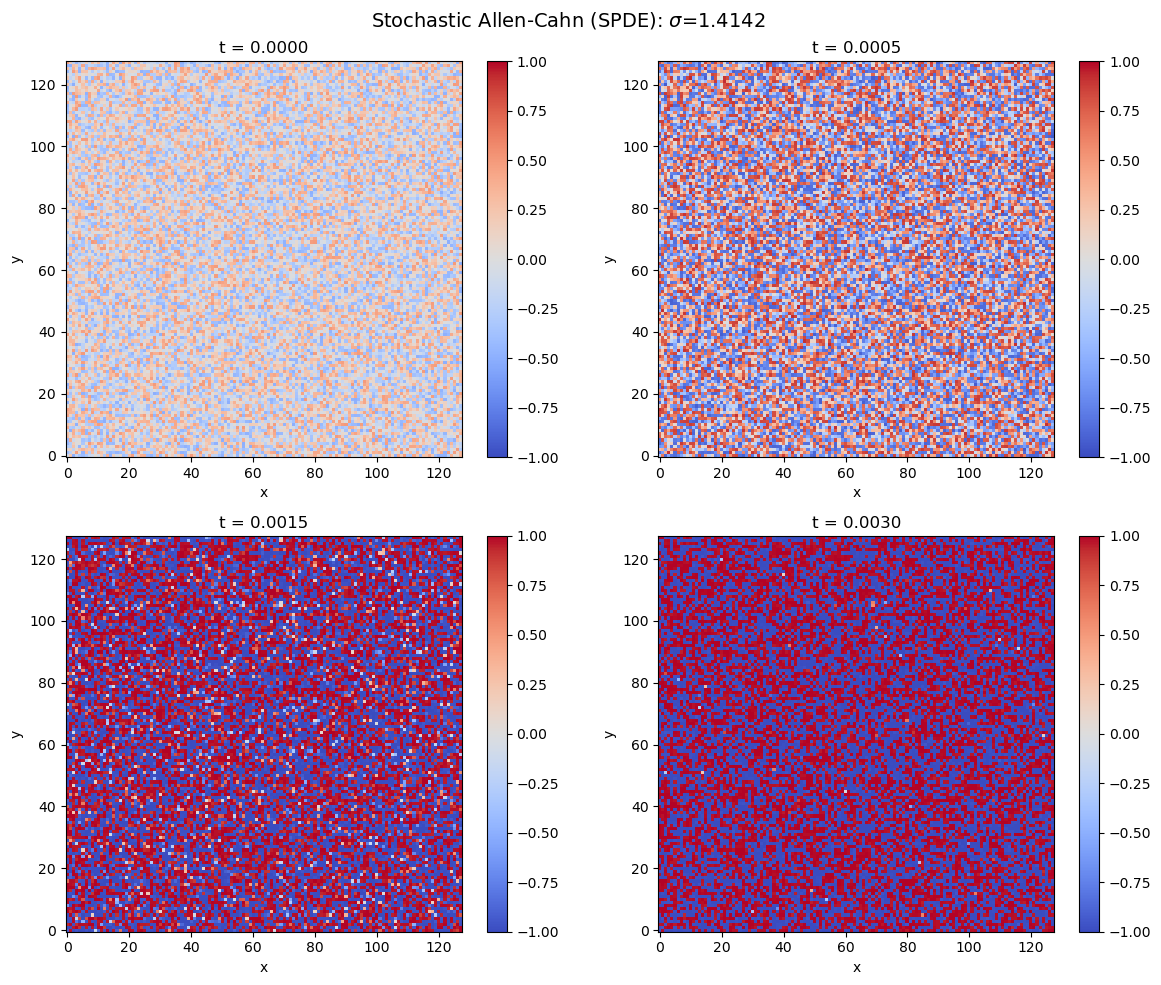

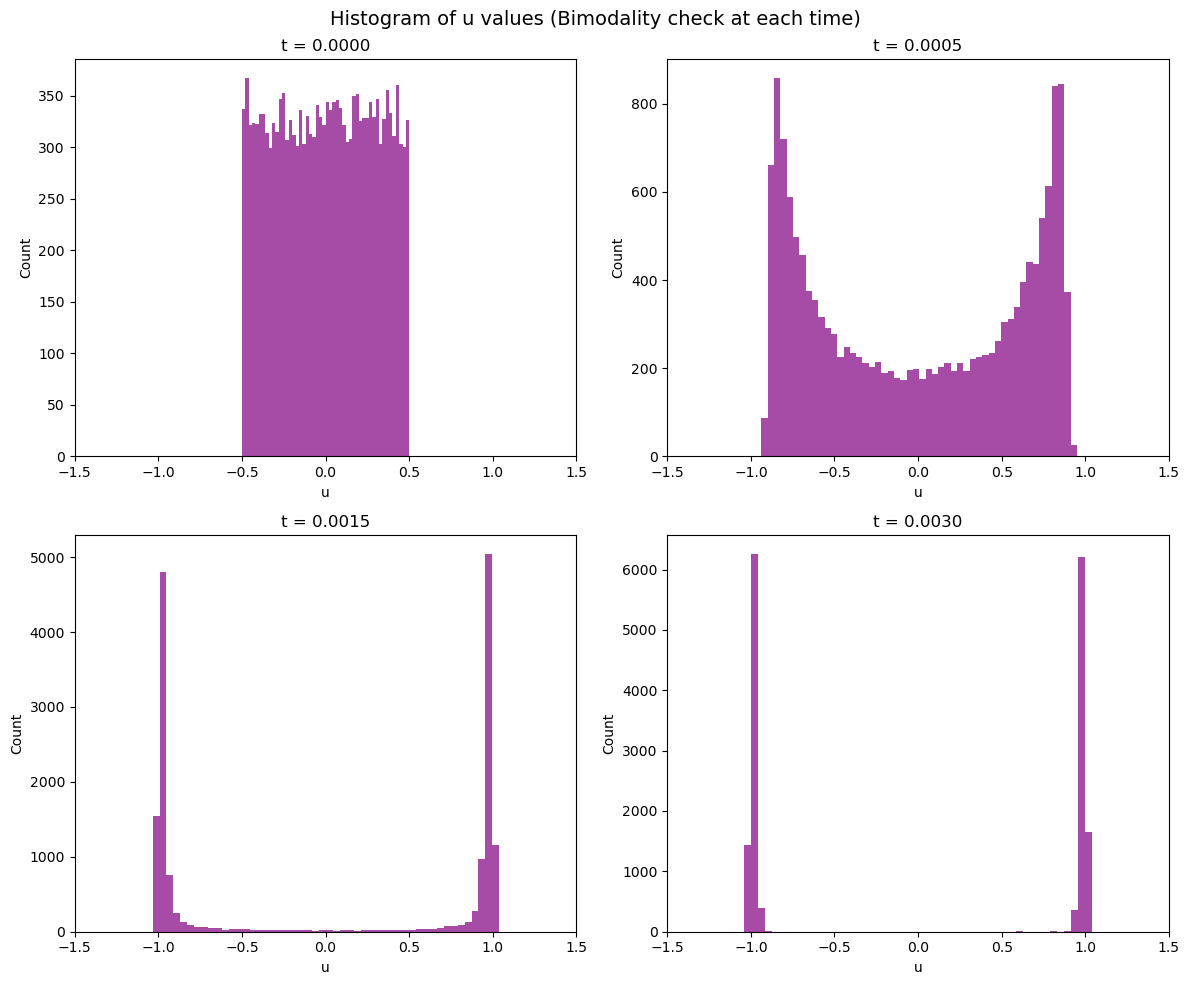

In [2]:
class StochasticAllenCahn2D:
    """
    Stochastic Allen-Cahn equation (SPDE) with additive noise:
    du/dt = D * Laplacian(u) - (1/eps^2) * u * (u^2 - 1) + sigma * dW
    
    where dW is the increment of a Wiener process (white noise).
    """
    def __init__(self, N=64, L=1.0, D=0.001, epsilon=0.01, sigma=0.1, dt=0.001):
        """
        N: Grid size (N x N)
        L: Physical domain size
        D: Diffusion coefficient
        epsilon: Interface width parameter
        sigma: Noise intensity (standard deviation per unit time)
        dt: Time step
        """
        self.N = N
        self.L = L
        self.D = D
        self.epsilon = epsilon
        self.sigma = sigma
        self.dt = dt
        self.dx = L / N
        
        # Noise scaling for Euler-Maruyama: sigma * sqrt(dt)
        self.noise_scale = sigma * np.sqrt(dt)
        
        # Initialize grid
        self.u = np.random.uniform(-0.5, 0.5, (N, N))
        
    def laplacian(self, u):
        """Finite difference approximation of Laplacian with Periodic BC"""
        u_top = np.roll(u, 1, axis=0)
        u_bottom = np.roll(u, -1, axis=0)
        u_left = np.roll(u, 1, axis=1)
        u_right = np.roll(u, -1, axis=1)
        return (u_top + u_bottom + u_left + u_right - 4*u) / (self.dx**2)

    def step(self):
        """Euler-Maruyama time stepping for SPDE"""
        # Deterministic part: reaction-diffusion
        reaction = -(1.0 / self.epsilon**2) * self.u * (self.u**2 - 1.0)
        diffusion = self.D * self.laplacian(self.u)
        
        # Stochastic part: additive white noise (Wiener increment)
        dW = self.noise_scale * np.random.randn(self.N, self.N)
        
        # Euler-Maruyama update
        self.u += self.dt * (diffusion + reaction) + dW

# Backward compatibility alias
AllenCahn2D = StochasticAllenCahn2D

# --- Simulation with snapshots at multiple time points ---
# sigma=0.1 is moderate noise intensity for stable simulation
ac_sim = StochasticAllenCahn2D(N=128, dt=1e-5, epsilon=0.02, sigma=1.4142)

# Define time points to capture
snapshot_times = np.array([0, 0.0005, 0.0015, 0.003])
snapshot_steps = set([int(t / ac_sim.dt) for t in snapshot_times])
total_steps = max(snapshot_steps)

snapshots = {}

# Save initial state (t=0)
snapshots[0] = ac_sim.u.copy()

print(f"Simulating Stochastic Allen-Cahn (SPDE) for {total_steps} steps...")
print(f"  Noise intensity: sigma = {ac_sim.sigma}")
print(f"  Epsilon: {ac_sim.epsilon}")

for step in tqdm(range(1, total_steps + 1)):
    ac_sim.step()
    if step in snapshot_steps:
        snapshots[step] = ac_sim.u.copy()

# Check for numerical issues
print(f"\nNumerical check:")
for step_num, data in snapshots.items():
    print(f"  Step {step_num}: min={data.min():.4f}, max={data.max():.4f}, "
          f"has_nan={np.any(np.isnan(data))}, has_inf={np.any(np.isinf(data))}")

# --- Visualization: Multiple time snapshots (2x2 layout) ---
n_snapshots = len(snapshot_times)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, t_phys in enumerate(snapshot_times):
    step_num = int(t_phys / ac_sim.dt)
    ax = axes[idx]
    im = ax.imshow(snapshots[step_num], cmap='coolwarm', origin='lower', vmin=-1, vmax=1)
    ax.set_title(f't = {t_phys:.4f}', fontsize=12)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.colorbar(im, ax=ax, fraction=0.046)

# Hide unused subplots
for idx in range(n_snapshots, len(axes)):
    axes[idx].axis('off')

plt.suptitle(f'Stochastic Allen-Cahn (SPDE): $\\sigma$={ac_sim.sigma}', fontsize=14)
plt.tight_layout()
plt.show()

# --- Histogram visualization for each time snapshot (2x2 layout) ---
fig2, axes2 = plt.subplots(2, 2, figsize=(12, 10))
axes2 = axes2.flatten()

for idx, t_phys in enumerate(snapshot_times):
    step_num = int(t_phys / ac_sim.dt)
    ax = axes2[idx]
    data = snapshots[step_num].flatten()
    # Filter out any inf/nan for histogram
    data = data[np.isfinite(data)]
    ax.hist(data, bins=50, color='purple', alpha=0.7)
    ax.set_title(f't = {t_phys:.4f}', fontsize=12)
    ax.set_xlabel('u')
    ax.set_ylabel('Count')
    ax.set_xlim(-1.5, 1.5)

# Hide unused subplots
for idx in range(n_snapshots, len(axes2)):
    axes2[idx].axis('off')

plt.suptitle('Histogram of u values (Bimodality check at each time)', fontsize=14)
plt.tight_layout()
plt.show()

## KSWGD Analysis: Learning the Distribution at Different Time Steps

We will use the **KSWGD (Koopman Spectral Wasserstein Gradient Descent)** method to:
1. Learn the distribution of spatial patterns at each time snapshot
2. Generate new samples from the learned distribution
3. Observe if the generated distribution captures the **bimodal structure** (δ-like peaks at ±1)

**Pipeline:**
- Each snapshot is a 128×128 = 16384-dimensional vector
- Use Autoencoder to reduce to a low-dimensional latent space
- Apply EDMD + KSWGD in latent space
- Decode back and visualize the distribution

In [3]:
# === Setup for KSWGD ===
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import PolynomialFeatures
from scipy.linalg import eig
from tqdm.auto import trange
import warnings
warnings.filterwarnings("ignore")

# Import KSWGD kernel functions
from grad_ker1 import grad_ker1
from K_tar_eval import K_tar_eval

# Try to import GPU versions
try:
    import cupy as cp
    from grad_ker1_gpu import grad_ker1 as grad_ker1_gpu
    from K_tar_eval_gpu import K_tar_eval as K_tar_eval_gpu
    KSWGD_GPU_AVAILABLE = True
except Exception:
    cp = None
    grad_ker1_gpu = None
    K_tar_eval_gpu = None
    KSWGD_GPU_AVAILABLE = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
use_gpu_kswgd = bool(KSWGD_GPU_AVAILABLE and torch.cuda.is_available())

print(f"Using device: {device}")
print(f"KSWGD GPU backend: {'enabled' if use_gpu_kswgd else 'disabled'}")

Using device: cuda
KSWGD GPU backend: enabled


In [4]:
# === Autoencoder for Allen-Cahn spatial patterns ===
# Input: 128x128 = 16384 dimensional vectors
# Latent: 8-16 dimensions (tunable)

class ACEncoder(nn.Module):
    """Encoder for Allen-Cahn 2D fields"""
    def __init__(self, input_size=128, latent_dim=8):
        super().__init__()
        self.input_size = input_size
        flat_size = input_size * input_size
        
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flat_size, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim),
        )
    
    def forward(self, x):
        return self.net(x)

class ACDecoder(nn.Module):
    """Decoder for Allen-Cahn 2D fields"""
    def __init__(self, input_size=128, latent_dim=8):
        super().__init__()
        self.input_size = input_size
        flat_size = input_size * input_size
        
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, flat_size),
            nn.Tanh(),  # Output in [-1, 1] range for Allen-Cahn
        )
    
    def forward(self, z):
        x_flat = self.net(z)
        return x_flat.view(-1, self.input_size, self.input_size)

class ACAutoencoder(nn.Module):
    """Autoencoder for Allen-Cahn 2D fields"""
    def __init__(self, input_size=128, latent_dim=8):
        super().__init__()
        self.encoder = ACEncoder(input_size, latent_dim)
        self.decoder = ACDecoder(input_size, latent_dim)
        self.latent_dim = latent_dim
    
    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z

print("Autoencoder architecture defined.")

Autoencoder architecture defined.


In [7]:
# === KSWGD Function for Allen-Cahn ===
# 
# TRUE TIME EVOLUTION VERSION:
# 1. Generate time series data: t=0, t=dt, t=2dt, ...
# 2. Use ONLY t=0 → t=dt pairs to build Koopman operator
# 3. Use Koopman to PREDICT distributions at future times
# 4. Compare predictions with ground truth

def generate_ac_time_series_ensemble(n_samples=200, N=128, dt_sim=1e-4, epsilon=0.1, 
                                      sigma=0.1, time_points=[0, 0.02, 0.05, 0.1], verbose=True):
    """
    Generate an ensemble of Stochastic Allen-Cahn (SPDE) time series from different initial conditions.
    Each simulation is saved at multiple time points.
    
    Args:
        n_samples: Number of independent simulations
        N: Grid size
        dt_sim: Simulation time step
        epsilon: Interface width parameter
        sigma: Noise intensity for SPDE
        time_points: List of times to save snapshots
        
    Returns:
        dict: {time: np.array of shape (n_samples, N, N)} for each time point
    """
    if verbose:
        print(f"  Generating {n_samples} independent Stochastic AC (SPDE) time series...")
        print(f"  Noise intensity: sigma = {sigma}")
        print(f"  Time points: {time_points}")
    
    # Convert time points to step numbers
    time_steps = {t: int(t / dt_sim) for t in time_points}
    max_steps = max(time_steps.values())
    
    # Initialize output dictionary
    ensemble = {t: [] for t in time_points}
    
    for i in tqdm(range(n_samples), desc="Ensemble generation", disable=not verbose):
        # Create new SPDE simulation with fresh random IC
        ac = StochasticAllenCahn2D(N=N, dt=dt_sim, epsilon=epsilon, sigma=sigma)
        ac.u = np.random.uniform(-0.5, 0.5, (N, N))
        
        current_step = 0
        
        # Save t=0 if needed
        if 0 in time_steps.values():
            for t, step in time_steps.items():
                if step == 0:
                    ensemble[t].append(ac.u.copy())
        
        # Evolve and save at target times
        for step in range(1, max_steps + 1):
            ac.step()
            current_step = step
            
            # Check if we need to save at this step
            for t, target_step in time_steps.items():
                if step == target_step and target_step > 0:
                    ensemble[t].append(ac.u.copy())
    
    # Convert to numpy arrays
    ensemble = {t: np.array(snapshots) for t, snapshots in ensemble.items()}
    
    if verbose:
        for t, data in ensemble.items():
            print(f"    t={t}: shape {data.shape}")
    
    return ensemble


def train_autoencoder_on_data(data_flat, N, latent_dim, n_epochs, verbose=True):
    """Train autoencoder on flattened data."""
    # Scale to [-1, 1]
    data_min = data_flat.min()
    data_max = data_flat.max()
    data_range = data_max - data_min + 1e-8
    data_scaled = 2.0 * (data_flat - data_min) / data_range - 1.0
    
    train_tensor = torch.FloatTensor(data_scaled).to(device)
    train_loader = DataLoader(TensorDataset(train_tensor), batch_size=32, shuffle=True)
    
    ae = ACAutoencoder(input_size=N, latent_dim=latent_dim).to(device)
    optimizer = optim.Adam(ae.parameters(), lr=1e-3)
    
    for epoch in range(n_epochs):
        total_loss = 0
        for (batch,) in train_loader:
            batch = batch.view(-1, N, N)
            optimizer.zero_grad()
            recon, z = ae(batch)
            loss = nn.MSELoss()(recon, batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        if verbose and (epoch + 1) % 25 == 0:
            print(f"    Epoch {epoch+1}/{n_epochs}, Loss: {total_loss/len(train_loader):.6f}")
    
    return ae, data_min, data_max


def run_kswgd_time_evolution(time_series_ensemble, latent_dim=8, poly_order=5,
                              m_particles=100, num_iters_kswgd=500, step_size_kswgd=0.1,
                              n_epochs_ae=100, verbose=True):
    """
    Run KSWGD with TRUE TIME EVOLUTION using Koopman operator.
    
    KEY DIFFERENCE from previous version:
    - Koopman operator is built from t=0 → t=dt data ONLY
    - Future time distributions are PREDICTED using repeated Koopman applications
    - We compare predictions vs ground truth at each future time
    
    Args:
        time_series_ensemble: dict {time: (n_samples, N, N)} from generate_ac_time_series_ensemble
        
    Returns:
        dict with predictions and ground truth at each time
    """
    time_points = sorted(time_series_ensemble.keys())
    if len(time_points) < 2:
        raise ValueError("Need at least 2 time points for time evolution")
    
    t0 = time_points[0]  # Initial time (usually 0)
    t1 = time_points[1]  # First time step (for building Koopman)
    dt_koopman = t1 - t0  # Time step for Koopman operator
    
    data_t0 = time_series_ensemble[t0]
    data_t1 = time_series_ensemble[t1]
    n_samples, N, _ = data_t0.shape
    
    if verbose:
        print(f"\n  === TRUE KOOPMAN TIME EVOLUTION ===")
        print(f"  Building Koopman from t={t0} → t={t1} (dt={dt_koopman})")
        print(f"  Will PREDICT distributions at t={time_points[2:]} using this operator")
        print(f"  Ensemble size: {n_samples}")
    
    # ============================================================
    # Step 1: Train Autoencoder on ALL time point data (for fair encoding)
    # ============================================================
    if verbose:
        print(f"\n  Training Autoencoder on all time data...")
    
    all_data = np.concatenate([time_series_ensemble[t] for t in time_points], axis=0)
    all_data_flat = all_data.reshape(-1, N*N)
    
    ae, data_min, data_max = train_autoencoder_on_data(
        all_data_flat, N, latent_dim, n_epochs_ae, verbose
    )
    data_range = data_max - data_min + 1e-8
    
    # ============================================================
    # Step 2: Encode t=0 and t=dt data to latent space
    # ============================================================
    ae.eval()
    
    def encode_data(data_3d):
        data_flat = data_3d.reshape(-1, N*N)
        data_scaled = 2.0 * (data_flat - data_min) / data_range - 1.0
        with torch.no_grad():
            tensor = torch.FloatTensor(data_scaled).to(device).view(-1, N, N)
            z = ae.encoder(tensor).cpu().numpy()
        return z.astype(np.float64)
    
    Z_t0 = encode_data(data_t0)  # Latent codes at t=0
    Z_t1 = encode_data(data_t1)  # Latent codes at t=dt
    
    if verbose:
        print(f"  Latent codes: Z_t0 {Z_t0.shape}, Z_t1 {Z_t1.shape}")
    
    # ============================================================
    # Step 3: Build EDMD Koopman Operator from (t0, t1) pairs
    # This is the KEY: we use PAIRED data (same IC at different times)
    # ============================================================
    if verbose:
        print(f"\n  Building EDMD Koopman operator (poly_order={poly_order})...")
    
    poly = PolynomialFeatures(degree=poly_order, include_bias=True)
    Phi_X = poly.fit_transform(Z_t0)  # Features at t=0
    Phi_Y = poly.transform(Z_t1)       # Features at t=dt
    n_features = Phi_X.shape[1]
    
    if verbose:
        print(f"    Polynomial features: {n_features}")
    
    # EDMD: K such that Phi_Y ≈ Phi_X @ K
    reg_edmd = 1e-4
    G_edmd = (Phi_X.T @ Phi_X) / n_samples + reg_edmd * np.eye(n_features)
    A_edmd = (Phi_X.T @ Phi_Y) / n_samples
    K_edmd = np.linalg.solve(G_edmd, A_edmd)  # Koopman operator in feature space
    
    if verbose:
        print(f"    Koopman operator K shape: {K_edmd.shape}")
    
    # ============================================================
    # Step 4: Build KSWGD operators from t=0 data (target distribution)
    # ============================================================
    if verbose:
        print(f"\n  Building KSWGD operators from t=0 distribution...")
    
    Z_tar = Z_t0
    sq_tar = np.sum(Z_tar ** 2, axis=1)
    
    kswgd_dists = pairwise_distances(Z_tar, metric="euclidean")
    eps_kswgd = np.median(kswgd_dists**2) / (2.0 * np.log(Z_tar.shape[0] + 1))
    eps_kswgd = float(max(eps_kswgd, 1e-6))
    
    data_kernel = np.exp(-kswgd_dists**2 / (2.0 * eps_kswgd))
    p_x = np.sqrt(np.sum(data_kernel, axis=1))
    data_kernel_norm = data_kernel / (p_x[:, None] * p_x[None, :] + 1e-12)
    
    D_y = np.sum(data_kernel_norm, axis=0)
    rw_kernel = 0.5 * (data_kernel_norm / (D_y + 1e-12) + data_kernel_norm / (D_y[:, None] + 1e-12))
    rw_kernel = np.nan_to_num(rw_kernel)
    
    lambda_ns_kernel, phi_kernel = np.linalg.eigh(rw_kernel)
    phi_kernel = np.real(phi_kernel[:, ::-1])
    lambda_ns_kernel = np.real(lambda_ns_kernel[::-1])
    
    tol_kswgd = 1e-6
    mask_kswgd = lambda_ns_kernel >= tol_kswgd
    above_tol = int(np.sum(mask_kswgd))
    phi_trunc_kswgd = phi_kernel[:, :above_tol]
    
    lambda_gen_kernel = lambda_ns_kernel - 1.0
    inv_lambda = np.zeros_like(lambda_gen_kernel)
    inv_lambda[1:] = 1.0 / np.clip(np.abs(lambda_gen_kernel[1:]), 1e-12, None)
    inv_lambda *= eps_kswgd
    
    lambda_ns_inv = np.zeros_like(lambda_ns_kernel)
    lambda_ns_inv[mask_kswgd] = eps_kswgd / (lambda_ns_kernel[mask_kswgd] + 1e-3)
    lambda_ns_s_ns_kswgd = (lambda_ns_inv * inv_lambda * lambda_ns_inv)[:above_tol]
    
    p_tar = np.sum(data_kernel, axis=0)
    sqrt_p = np.sqrt(p_tar + 1e-12)
    D_vec = np.sum(data_kernel / sqrt_p[:, None] / sqrt_p[None, :], axis=1)
    
    if verbose:
        print(f"    Using {above_tol} kernel eigenfunctions")
    
    # ============================================================
    # Step 5: KSWGD to sample from t=0 distribution
    # ============================================================
    if verbose:
        print(f"\n  Running KSWGD to sample t=0 distribution...")
    
    rng_kswgd = np.random.default_rng(1)
    grad_fn = grad_ker1_gpu if use_gpu_kswgd else grad_ker1
    K_eval_fn = K_tar_eval_gpu if use_gpu_kswgd else K_tar_eval
    xp = cp if use_gpu_kswgd else np
    
    # Initialize from scaled Gaussian
    z_std = np.std(Z_t0, axis=0)
    z_mean = np.mean(Z_t0, axis=0)
    init_particles = rng_kswgd.normal(0.0, 1.0, size=(m_particles, latent_dim)) * z_std + z_mean
    
    if use_gpu_kswgd:
        Z_tar_dev = cp.asarray(Z_tar)
        p_tar_dev = cp.asarray(p_tar)
        sq_tar_dev = cp.asarray(sq_tar)
        D_vec_dev = cp.asarray(D_vec)
        phi_trunc_dev = cp.asarray(phi_trunc_kswgd)
        lambda_ns_s_ns_dev = cp.asarray(lambda_ns_s_ns_kswgd)
        z_hist = cp.zeros((m_particles, latent_dim, num_iters_kswgd), dtype=cp.float64)
        z_hist[:, :, 0] = cp.asarray(init_particles, dtype=cp.float64)
    else:
        Z_tar_dev = Z_tar
        p_tar_dev = p_tar
        sq_tar_dev = sq_tar
        D_vec_dev = D_vec
        phi_trunc_dev = phi_trunc_kswgd
        lambda_ns_s_ns_dev = lambda_ns_s_ns_kswgd
        z_hist = np.zeros((m_particles, latent_dim, num_iters_kswgd), dtype=np.float64)
        z_hist[:, :, 0] = init_particles
    
    for t in range(num_iters_kswgd - 1):
        grad_matrix = grad_fn(z_hist[:, :, t], Z_tar_dev, p_tar_dev, sq_tar_dev, D_vec_dev, eps_kswgd)
        cross_matrix = K_eval_fn(Z_tar_dev, z_hist[:, :, t], p_tar_dev, sq_tar_dev, D_vec_dev, eps_kswgd)
        
        tmp = phi_trunc_dev.T @ cross_matrix
        tmp = lambda_ns_s_ns_dev[:, None] * tmp
        kswgd_push = phi_trunc_dev @ tmp
        
        for d in range(latent_dim):
            sum_term = grad_matrix[:, :, d] @ kswgd_push
            z_hist[:, d, t + 1] = z_hist[:, d, t] - (step_size_kswgd / m_particles) * xp.sum(sum_term, axis=1)
    
    # Particles at t=0 (from KSWGD)
    if use_gpu_kswgd:
        Z_particles_t0 = cp.asnumpy(z_hist[:, :, -1])
    else:
        Z_particles_t0 = z_hist[:, :, -1]
    
    if verbose:
        print(f"    Generated {m_particles} particles at t=0")
    
    # ============================================================
    # Step 6: Use Koopman to PREDICT future time distributions
    # ============================================================
    if verbose:
        print(f"\n  === KOOPMAN TIME EVOLUTION ===")
        print(f"  Predicting future distributions using Koopman operator...")
    
    results = {}
    
    # Store t=0 results
    results[t0] = {
        'predicted_latent': Z_particles_t0,
        'ground_truth_latent': Z_t0,
    }
    
    # Current particles in latent space
    Z_current = Z_particles_t0.copy()
    
    for i, t_target in enumerate(time_points[1:], 1):
        # Number of Koopman steps needed: t_target / dt_koopman
        # This correctly handles non-uniform time spacing
        n_koopman_steps = int(round(t_target / dt_koopman))
        
        if verbose:
            print(f"\n    t = {t_target}: applying Koopman {n_koopman_steps} time(s) (dt={dt_koopman})")
        
        # Apply Koopman operator n_koopman_steps times starting from t=0
        Z_pred = Z_particles_t0.copy()
        
        # Get bounds from training data for stability clipping
        z_bounds = np.max(np.abs(Z_t0)) * 3.0  # Allow 3x the original range
        
        for step in range(n_koopman_steps):
            # Transform to feature space
            Phi_pred = poly.transform(Z_pred)
            # Apply Koopman
            Phi_next = Phi_pred @ K_edmd
            # Extract latent coordinates (first latent_dim features after bias)
            # Note: PolynomialFeatures with include_bias=True puts bias first,
            # then degree-1 terms (which are the original coordinates)
            Z_pred = Phi_next[:, 1:latent_dim+1]
            
            # Stability check: clip to prevent numerical explosion
            Z_pred = np.clip(Z_pred, -z_bounds, z_bounds)
            
            # Check for NaN and replace with mean if needed
            if np.any(np.isnan(Z_pred)):
                nan_mask = np.isnan(Z_pred)
                Z_pred[nan_mask] = np.nanmean(Z_t0)
                if verbose:
                    print(f"        Warning: NaN detected at step {step+1}, replaced with mean")
        
        # Get ground truth at this time
        Z_gt = encode_data(time_series_ensemble[t_target])
        
        results[t_target] = {
            'predicted_latent': Z_pred,
            'ground_truth_latent': Z_gt,
            'n_koopman_steps': n_koopman_steps,
        }
        
        if verbose:
            print(f"      Predicted latent mean: {Z_pred.mean(axis=0)[:3]}...")
            print(f"      Ground truth mean:     {Z_gt.mean(axis=0)[:3]}...")
    
    # ============================================================
    # Step 7: Decode all predictions and ground truths
    # ============================================================
    if verbose:
        print(f"\n  Decoding predictions to original space...")
    
    def decode_latent(z_latent):
        with torch.no_grad():
            z_tensor = torch.FloatTensor(z_latent).to(device)
            decoded = ae.decoder(z_tensor).cpu().numpy()
        # Rescale back
        samples = (decoded.reshape(-1, N*N) + 1.0) / 2.0 * data_range + data_min
        return samples.reshape(-1, N, N)
    
    for t in time_points:
        results[t]['predicted_samples'] = decode_latent(results[t]['predicted_latent'])
        results[t]['ground_truth_samples'] = time_series_ensemble[t]
    
    results['meta'] = {
        'time_points': time_points,
        'dt_koopman': dt_koopman,
        'ae': ae,
        'K_edmd': K_edmd,
        'poly': poly,
    }
    
    if verbose:
        print(f"\n  Time evolution complete!")
    
    return results

print("KSWGD functions defined (TRUE TIME EVOLUTION version).")
print("\nKey difference from previous version:")
print("  - Koopman operator is built from t=0 → t=dt data ONLY")
print("  - Future distributions are PREDICTED (not fitted)")
print("  - This tests Koopman's predictive ability!")

KSWGD functions defined (TRUE TIME EVOLUTION version).

Key difference from previous version:
  - Koopman operator is built from t=0 → t=dt data ONLY
  - Future distributions are PREDICTED (not fitted)
  - This tests Koopman's predictive ability!


In [8]:
# === Run TRUE TIME EVOLUTION with Koopman Operator ===
#
# This version:
# 1. Builds Koopman operator from t=0 → t=dt pairs ONLY
# 2. Uses Koopman to PREDICT future distributions
# 3. Compares predictions with ground truth

# Define time points (matching snapshot_times in Cell 3: 0 to 0.003)
# t=0 is initial, t=0.0005 is used to build Koopman, t=0.0015 and t=0.003 are PREDICTED
time_points = [0, 0.0005, 0.0015, 0.003]

# SPDE parameters
EPSILON_PDE = 0.02  # Interface width parameter (smaller = sharper interface)
SIGMA_NOISE = 0.1   # Noise intensity (moderate for stable simulation)

print("="*70)
print("TRUE KOOPMAN TIME EVOLUTION for Stochastic Allen-Cahn (SPDE)")
print("="*70)
print(f"\nEpsilon (interface width): {EPSILON_PDE}")
print(f"Noise intensity: sigma = {SIGMA_NOISE}")
print(f"Time points: {time_points}")
print(f"  - t={time_points[0]} → t={time_points[1]}: Used to BUILD Koopman operator")
print(f"  - t={time_points[2:]}: PREDICTED using Koopman (not used in training!)")
print()

# Step 1: Generate time series ensemble
print("Step 1: Generating SPDE time series ensemble...")
time_series_ensemble = generate_ac_time_series_ensemble(
    n_samples=300,  # Increased from 150 to improve EDMD stability
    N=128,
    dt_sim=1e-5,  # Smaller dt for stability with smaller epsilon
    epsilon=EPSILON_PDE,  # Interface width parameter
    sigma=SIGMA_NOISE,    # Noise intensity
    time_points=time_points,
    verbose=True
)

# Print statistics at each time
print("\nEnsemble statistics at each time:")
for t, data in time_series_ensemble.items():
    print(f"  t={t}: mean={data.mean():.4f}, std={data.std():.4f}, "
          f"min={data.min():.4f}, max={data.max():.4f}")

# Step 2: Run KSWGD with true time evolution
print("\n" + "="*70)
print("Step 2: Running KSWGD with Koopman Time Evolution")
print("="*70)

kswgd_time_results = run_kswgd_time_evolution(
    time_series_ensemble,
    latent_dim=8,
    poly_order=2,  # Reduced from 4 to 2 for numerical stability with multi-step Koopman
    m_particles=100,
    num_iters_kswgd=500,
    step_size_kswgd=0.05,
    n_epochs_ae=100,
    verbose=True
)

print("\n" + "="*70)
print("Koopman time evolution complete!")
print("="*70)

TRUE KOOPMAN TIME EVOLUTION for Stochastic Allen-Cahn (SPDE)

Epsilon (interface width): 0.02
Noise intensity: sigma = 0.1
Time points: [0, 0.0005, 0.0015, 0.003]
  - t=0 → t=0.0005: Used to BUILD Koopman operator
  - t=[0.0015, 0.003]: PREDICTED using Koopman (not used in training!)

Step 1: Generating SPDE time series ensemble...
  Generating 300 independent Stochastic AC (SPDE) time series...
  Noise intensity: sigma = 0.1
  Time points: [0, 0.0005, 0.0015, 0.003]


Ensemble generation: 100%|██████████| 300/300 [00:25<00:00, 11.79it/s]


    t=0: shape (300, 128, 128)
    t=0.0005: shape (300, 128, 128)
    t=0.0015: shape (300, 128, 128)
    t=0.003: shape (300, 128, 128)

Ensemble statistics at each time:
  t=0: mean=-0.0001, std=0.2887, min=-0.5000, max=0.5000
  t=0.0005: mean=-0.0003, std=0.6320, min=-0.8975, max=0.8988
  t=0.0015: mean=-0.0007, std=0.9478, min=-1.0027, max=1.0028
  t=0.003: mean=-0.0008, std=0.9859, min=-1.0044, max=1.0042

Step 2: Running KSWGD with Koopman Time Evolution

  === TRUE KOOPMAN TIME EVOLUTION ===
  Building Koopman from t=0 → t=0.0005 (dt=0.0005)
  Will PREDICT distributions at t=[0.0015, 0.003] using this operator
  Ensemble size: 300

  Training Autoencoder on all time data...
    Epoch 25/100, Loss: 0.029148
    Epoch 50/100, Loss: 0.061997
    Epoch 75/100, Loss: 0.013471
    Epoch 100/100, Loss: 0.038231
  Latent codes: Z_t0 (300, 8), Z_t1 (300, 8)

  Building EDMD Koopman operator (poly_order=2)...
    Polynomial features: 45
    Koopman operator K shape: (45, 45)

  Building 

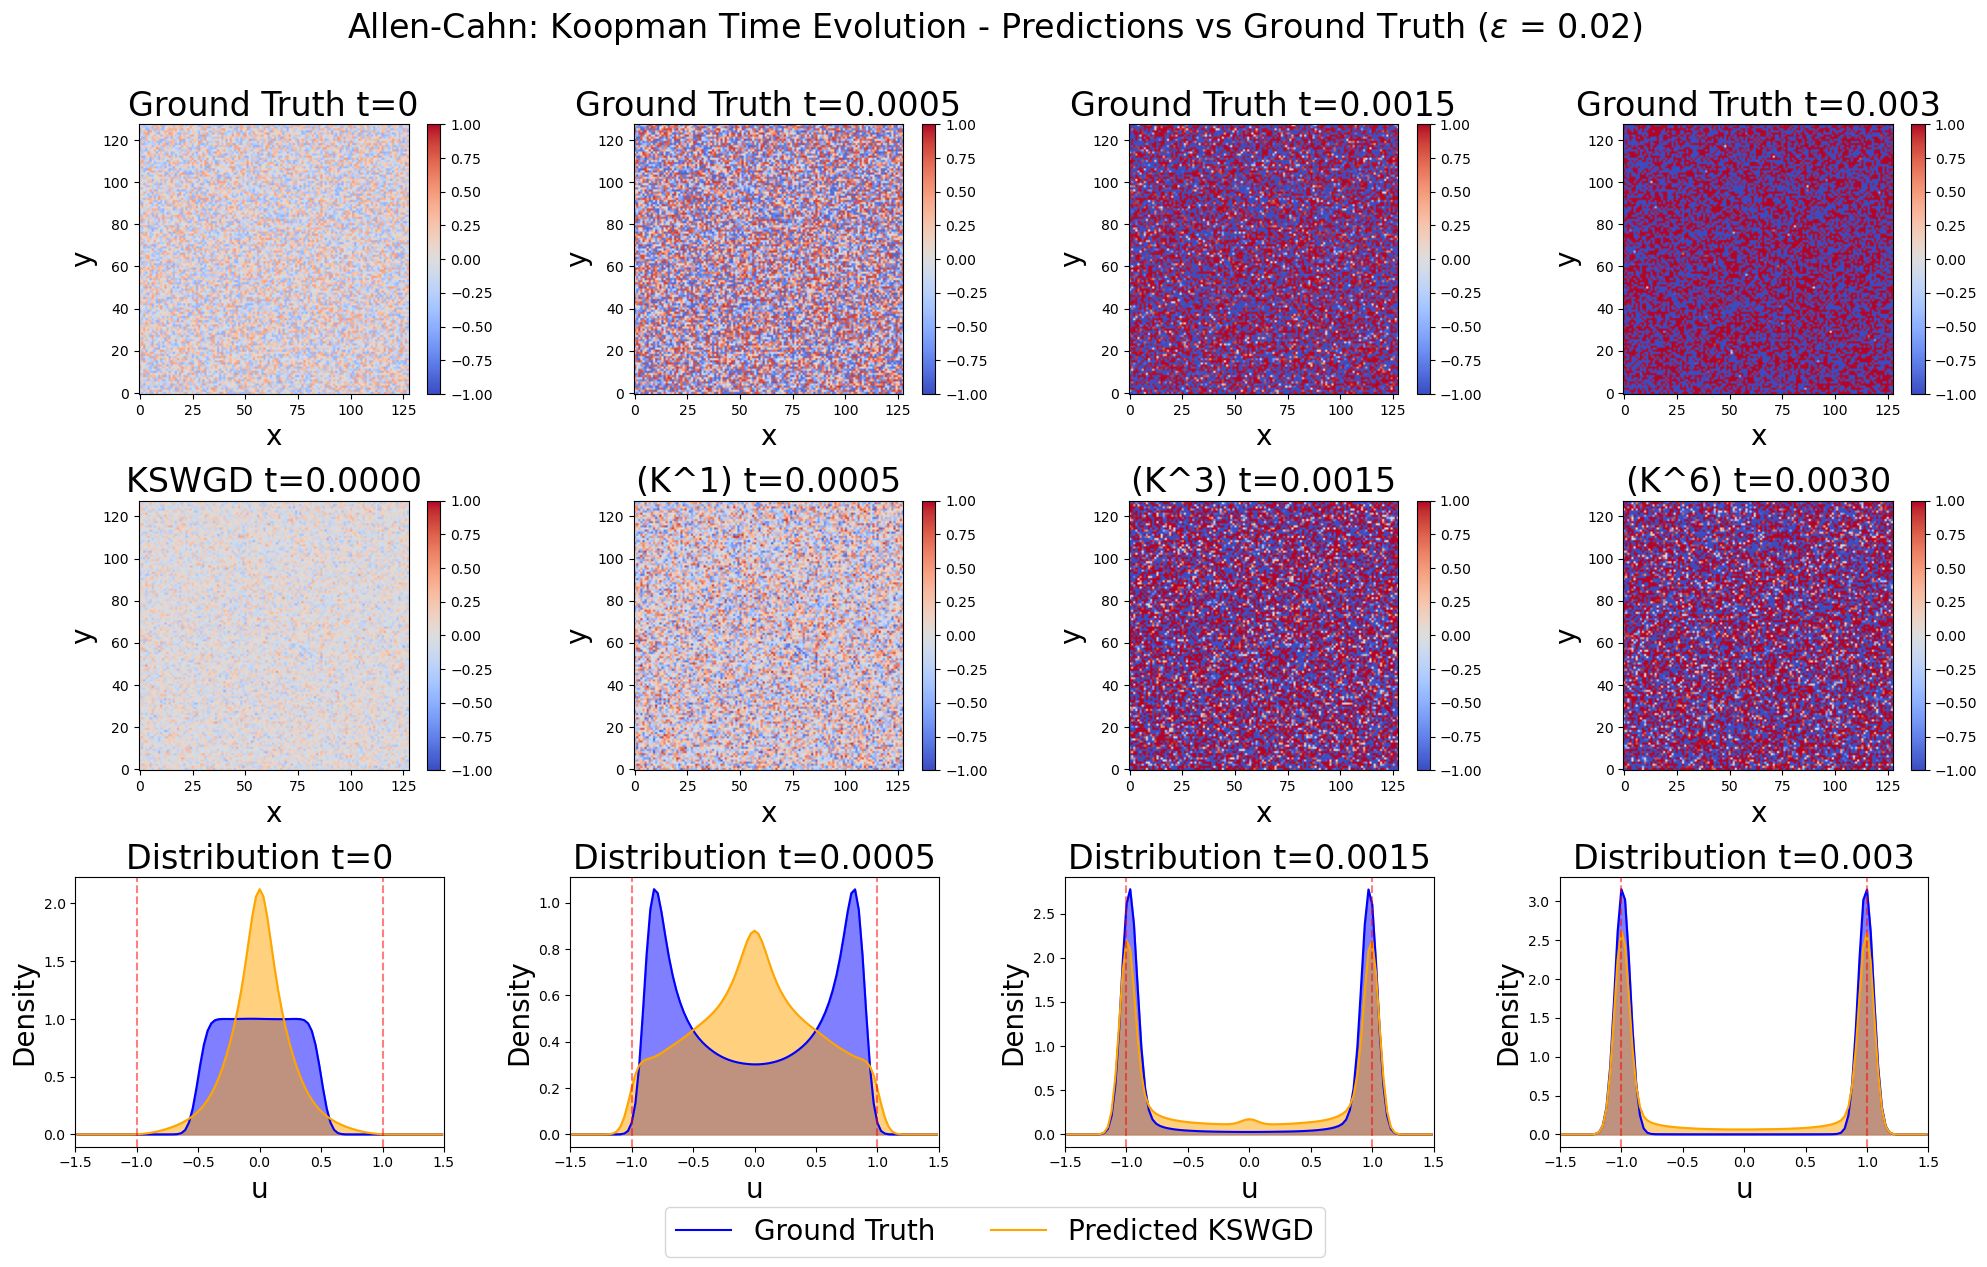


Distribution Statistics: Ground Truth vs Koopman Predictions

t = 0 (KSWGD):
  Ground Truth: mean=-0.0001, std=0.2887, near ±1: 0.0%
  Predicted:    mean=-0.0003, std=0.2461, near ±1: 0.5%

t = 0.0005 (K^1):
  Ground Truth: mean=-0.0003, std=0.6320, near ±1: 25.3%
  Predicted:    mean=-0.0008, std=0.5078, near ±1: 14.1%

t = 0.0015 (K^3):
  Ground Truth: mean=-0.0007, std=0.9478, near ±1: 92.7%
  Predicted:    mean=-0.0017, std=0.8920, near ±1: 76.5%

t = 0.003 (K^6):
  Ground Truth: mean=-0.0008, std=0.9859, near ±1: 99.8%
  Predicted:    mean=-0.0037, std=0.9398, near ±1: 86.4%


In [9]:
# === Visualization: Koopman Predictions vs Ground Truth ===
from scipy.ndimage import gaussian_filter1d

time_points = kswgd_time_results['meta']['time_points']
n_times = len(time_points)

fig, axes = plt.subplots(3, n_times, figsize=(5*n_times, 13))

# Store line handles for shared legend
legend_handles = []
legend_labels = []

for col, t_phys in enumerate(time_points):
    result = kswgd_time_results[t_phys]
    gt_samples = result['ground_truth_samples']
    pred_samples = result['predicted_samples']
    
    n_koopman = result.get('n_koopman_steps', 0)
    title_suffix = f"(K^{n_koopman})" if n_koopman > 0 else "KSWGD"
    
    # Row 1: Ground Truth Sample
    ax = axes[0, col]
    im = ax.imshow(gt_samples[0], cmap='coolwarm', origin='lower', vmin=-1, vmax=1)
    ax.set_title(f'Ground Truth t={t_phys}', fontsize=24)
    ax.set_xlabel('x', fontsize=20)
    ax.set_ylabel('y', fontsize=20)
    plt.colorbar(im, ax=ax, fraction=0.046)
    
    # Row 2: Koopman Predicted Sample
    ax = axes[1, col]
    im = ax.imshow(pred_samples[0], cmap='coolwarm', origin='lower', vmin=-1, vmax=1)
    t_pred = 0.0005 * n_koopman if n_koopman > 0 else 0
    ax.set_title(f'{title_suffix} t={t_pred:.4f}', fontsize=24)
    ax.set_xlabel('x', fontsize=20)
    ax.set_ylabel('y', fontsize=20)
    plt.colorbar(im, ax=ax, fraction=0.046)
    
    # Row 3: Distribution Comparison using KDE (smoothed)
    ax = axes[2, col]
    gt_values = gt_samples.flatten()
    pred_values = pred_samples.flatten()
    
    # Use histogram with smoothing (Gaussian kernel density estimation approximation)
    bins = np.linspace(-1.5, 1.5, 100)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Compute histograms
    gt_hist, _ = np.histogram(gt_values, bins=bins, density=True)
    pred_hist, _ = np.histogram(pred_values, bins=bins, density=True)
    
    # Apply Gaussian smoothing to make the distribution smoother
    # This helps visualize the bimodal peaks better
    sigma = 2  # Smoothing parameter
    gt_hist_smooth = gaussian_filter1d(gt_hist, sigma=sigma)
    pred_hist_smooth = gaussian_filter1d(pred_hist, sigma=sigma)
    
    # Plot smoothed distributions (no individual legend)
    ax.fill_between(bin_centers, gt_hist_smooth, alpha=0.5, color='blue')
    l1, = ax.plot(bin_centers, gt_hist_smooth, color='blue', linewidth=1.5)
    ax.fill_between(bin_centers, pred_hist_smooth, alpha=0.5, color='orange')
    l2, = ax.plot(bin_centers, pred_hist_smooth, color='orange', linewidth=1.5)
    
    # Store handles from first column only
    if col == 0:
        legend_handles = [l1, l2]
        legend_labels = ['Ground Truth', f'Predicted {title_suffix}']
    
    ax.set_xlabel('u', fontsize=20)
    ax.set_ylabel('Density', fontsize=20)
    ax.set_title(f'Distribution t={t_phys}', fontsize=24)
    ax.set_xlim(-1.5, 1.5)
    ax.axvline(x=-1, color='red', linestyle='--', alpha=0.5)
    ax.axvline(x=1, color='red', linestyle='--', alpha=0.5)

# Add shared horizontal legend at the bottom
fig.legend(legend_handles, legend_labels, 
           loc='lower center', 
           ncol=2,  # Horizontal layout
           fontsize=20,
           frameon=True,
           bbox_to_anchor=(0.5, 0.01))

plt.suptitle(f'Allen-Cahn: Koopman Time Evolution - Predictions vs Ground Truth ($\\epsilon$ = {EPSILON_PDE})', fontsize=24)
plt.tight_layout(rect=[0, 0.05, 1, 0.97])  # Leave space for legend at bottom
plt.show()

# === Distribution Distance Metrics ===
from scipy.stats import wasserstein_distance

def compute_wasserstein_2(p_samples, q_samples):
    """Compute Wasserstein-2 distance for 1D distributions."""
    p_sorted = np.sort(p_samples)
    q_sorted = np.sort(q_samples)
    n = min(len(p_sorted), len(q_sorted))
    p_interp = np.interp(np.linspace(0, 1, n), np.linspace(0, 1, len(p_sorted)), p_sorted)
    q_interp = np.interp(np.linspace(0, 1, n), np.linspace(0, 1, len(q_sorted)), q_sorted)
    w2 = np.sqrt(np.mean((p_interp - q_interp)**2))
    return w2

# Print statistics comparison
print("\n" + "="*70)
print("Distribution Statistics: Ground Truth vs Koopman Predictions")
print("="*70)

for t_phys in time_points:
    result = kswgd_time_results[t_phys]
    gt = result['ground_truth_samples'].flatten()
    pred = result['predicted_samples'].flatten()
    n_koopman = result.get('n_koopman_steps', 0)
    
    # Fraction near ±1 (bimodality measure)
    gt_near_pm1 = np.mean(np.abs(gt) > 0.8)
    pred_near_pm1 = np.mean(np.abs(pred) > 0.8)
    
    method = f"K^{n_koopman}" if n_koopman > 0 else "KSWGD"
    
    print(f"\nt = {t_phys} ({method}):")
    print(f"  Ground Truth: mean={np.mean(gt):.4f}, std={np.std(gt):.4f}, near ±1: {gt_near_pm1:.1%}")
    print(f"  Predicted:    mean={np.mean(pred):.4f}, std={np.std(pred):.4f}, near ±1: {pred_near_pm1:.1%}")

## Baseline Comparison: Diffusion, VAE, Normalizing Flow & GAN
We benchmark KSWGD against four latent-space generators:
1. **Diffusion Model (DDPM)** – noise-conditioned denoiser.
2. **Variational Autoencoder (VAE)** – latent-variable model with KL control.
3. **Normalizing Flow (RealNVP)** – invertible density model with exact likelihoods.
4. **GAN (WGAN-GP)** – adversarial sampler learning a deterministic map.

All baselines:
- Train separately for each time slice using the shared AE latent space.
- Draw the same number of samples for evaluation.
- Share decoding + metrics so comparisons remain apples-to-apples.

In [10]:
# === Diffusion / VAE / Normalizing Flow / GAN baselines (latent space) ===
print("="*70)
print("Training Latent-Space Baselines for Allen-Cahn")
print("="*70)

class DiffusionModel(nn.Module):
    """MLP-based diffusion model for latent space."""
    def __init__(self, latent_dim, hidden_dim=256, time_emb_dim=64):
        super().__init__()
        self.latent_dim = latent_dim
        self.time_mlp = nn.Sequential(
            nn.Linear(1, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim)
        )
        self.net = nn.Sequential(
            nn.Linear(latent_dim + time_emb_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, latent_dim)
        )
    
    def forward(self, x, t):
        t_emb = self.time_mlp(t.unsqueeze(-1))
        x_t = torch.cat([x, t_emb], dim=-1)
        return self.net(x_t)

class VAELatent(nn.Module):
    """VAE operating in latent space (latent -> smaller latent -> latent)."""
    def __init__(self, latent_dim, hidden_dim=128, vae_latent_dim=4):
        super().__init__()
        self.vae_latent_dim = vae_latent_dim
        self.encoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
)
        self.fc_mu = nn.Linear(hidden_dim, vae_latent_dim)
        self.fc_var = nn.Linear(hidden_dim, vae_latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(vae_latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
)
    
    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_var(h)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

class AffineCoupling(nn.Module):
    """Single RealNVP affine coupling layer."""
    def __init__(self, dim, hidden_dim, mask):
        super().__init__()
        self.register_buffer('mask', mask)
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2 * dim)
        )
    
    def forward(self, x, reverse=False):
        masked_x = x * self.mask
        s_t = self.net(masked_x)
        s, t = torch.chunk(s_t, 2, dim=1)
        s = torch.tanh(s)  # stabilize scaling
        one_minus = 1 - self.mask
        if not reverse:  # data -> base
            y = masked_x + one_minus * (x * torch.exp(s) + t)
            log_det = torch.sum(one_minus * s, dim=1)
        else:  # base -> data
            y = masked_x + one_minus * ((x - t) * torch.exp(-s))
            log_det = -torch.sum(one_minus * s, dim=1)
        return y, log_det

class RealNVPFlow(nn.Module):
    """Stack of coupling layers implementing a normalizing flow."""
    def __init__(self, dim, hidden_dim=128, n_layers=4):
        super().__init__()
        self.dim = dim
        masks = []
        for i in range(n_layers):
            mask_pattern = (torch.arange(dim) % 2 == (i % 2)).float()
            masks.append(mask_pattern)
        self.layers = nn.ModuleList([AffineCoupling(dim, hidden_dim, mask) for mask in masks])
    
    def _forward_layers(self, x, reverse=False):
        log_det_sum = 0.0
        layers = list(reversed(self.layers)) if reverse else self.layers
        for layer in layers:
            x, log_det = layer(x, reverse=reverse)
            log_det_sum = log_det_sum + log_det
        return x, log_det_sum
    
    def log_prob(self, x):
        z, log_det = self._forward_layers(x, reverse=False)
        log_base = -0.5 * (z**2 + torch.log(torch.tensor(2 * np.pi, device=z.device))).sum(dim=1)
        return log_base + log_det
    
    def sample(self, n_samples):
        z = torch.randn(n_samples, self.dim, device=device)
        x, _ = self._forward_layers(z, reverse=True)
        return x

class LatentGenerator(nn.Module):
    """Simple generator for latent GAN."""
    def __init__(self, latent_dim, noise_dim=16, hidden_dim=256):
        super().__init__()
        self.noise_dim = noise_dim
        self.net = nn.Sequential(
            nn.Linear(noise_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, latent_dim)
)
    
    def forward(self, z):
        return self.net(z)

class LatentCritic(nn.Module):
    """WGAN-GP critic over latent vectors."""
    def __init__(self, latent_dim, hidden_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, 1)
)
    
    def forward(self, x):
        return self.net(x).squeeze(-1)

def gradient_penalty(critic, real, fake):
    batch_size = real.size(0)
    epsilon = torch.rand(batch_size, 1, device=real.device)
    interp = epsilon * real + (1 - epsilon) * fake
    interp.requires_grad_(True)
    scores = critic(interp)
    gradients = torch.autograd.grad(
        outputs=scores, inputs=interp,
        grad_outputs=torch.ones_like(scores),
        create_graph=True, retain_graph=True, only_inputs=True
    )[0]
    gradients = gradients.view(batch_size, -1)
    gp = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gp

def train_latent_baselines_for_time(time_series_ensemble, target_time, ae, data_min, data_max,
                                      latent_dim=8, n_epochs=150, n_samples_gen=100, verbose=True):
    """Train Diffusion, VAE, RealNVP flow, and GAN for a specific time point."""
    data_range = data_max - data_min + 1e-8
    data = time_series_ensemble[target_time]
    n_samples, N, _ = data.shape
    
    # Encode to latent space
    ae.eval()
    data_flat = data.reshape(-1, N*N)
    data_scaled = 2.0 * (data_flat - data_min) / data_range - 1.0
    with torch.no_grad():
        tensor = torch.FloatTensor(data_scaled).to(device).view(-1, N, N)
        Z_data = ae.encoder(tensor).cpu().numpy()
    
    # Normalize latent codes
    z_mean = Z_data.mean(axis=0)
    z_std = Z_data.std(axis=0) + 1e-8
    Z_norm = (Z_data - z_mean) / z_std
    
    train_tensor = torch.FloatTensor(Z_norm).to(device)
    train_loader = DataLoader(TensorDataset(train_tensor), batch_size=32, shuffle=True)
    
    # ---------------------------------------------------------------
    # Diffusion model
    # ---------------------------------------------------------------
    if verbose:
        print(f"\n  Training Diffusion Model for t={target_time}...")
    n_timesteps = 200
    betas = torch.linspace(1e-4, 0.02, n_timesteps).to(device)
    alphas = 1 - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0)
    diffusion = DiffusionModel(latent_dim, hidden_dim=256).to(device)
    optimizer_diff = optim.Adam(diffusion.parameters(), lr=1e-3)

    def q_sample(x0, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x0)
        sqrt_alpha_cumprod = torch.sqrt(alphas_cumprod[t]).unsqueeze(-1)
        sqrt_one_minus = torch.sqrt(1 - alphas_cumprod[t]).unsqueeze(-1)
        return sqrt_alpha_cumprod * x0 + sqrt_one_minus * noise, noise

    for epoch in range(n_epochs):
        total_loss = 0.0
        for (batch,) in train_loader:
            optimizer_diff.zero_grad()
            t = torch.randint(0, n_timesteps, (batch.shape[0],), device=device)
            x_noisy, noise = q_sample(batch, t)
            noise_pred = diffusion(x_noisy, t.float() / n_timesteps)
            loss = nn.MSELoss()(noise_pred, noise)
            loss.backward()
            optimizer_diff.step()
            total_loss += loss.item()
        if verbose and (epoch + 1) % 50 == 0:
            print(f"    Diffusion Epoch {epoch+1}/{n_epochs}, Loss: {total_loss/len(train_loader):.6f}")

    @torch.no_grad()
    def sample_diffusion(model, n_samples):
        x = torch.randn(n_samples, latent_dim, device=device)
        for t in reversed(range(n_timesteps)):
            t_batch = torch.full((n_samples,), t, device=device)
            noise_pred = model(x, t_batch.float() / n_timesteps)
            alpha = alphas[t]
            alpha_cumprod_t = alphas_cumprod[t]
            beta = betas[t]
            noise = torch.randn_like(x) if t > 0 else 0
            x = (1 / torch.sqrt(alpha)) * (x - (beta / torch.sqrt(1 - alpha_cumprod_t)) * noise_pred)
            x = x + torch.sqrt(beta) * noise
        return x

    diff_latent_norm = sample_diffusion(diffusion, n_samples_gen).cpu().numpy()
    diff_latent = diff_latent_norm * z_std + z_mean

    # ---------------------------------------------------------------
    # Variational Autoencoder
    # ---------------------------------------------------------------
    if verbose:
        print(f"\n  Training VAE for t={target_time}...")
    vae = VAELatent(latent_dim, hidden_dim=128, vae_latent_dim=4).to(device)
    optimizer_vae = optim.Adam(vae.parameters(), lr=1e-3)

    def vae_loss(recon_x, x, mu, log_var, beta=0.1):
        recon_loss = nn.MSELoss(reduction='sum')(recon_x, x)
        kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        return recon_loss + beta * kl_loss

    for epoch in range(n_epochs):
        total_loss = 0.0
        for (batch,) in train_loader:
            optimizer_vae.zero_grad()
            recon, mu, log_var = vae(batch)
            loss = vae_loss(recon, batch, mu, log_var, beta=0.1)
            loss.backward()
            optimizer_vae.step()
            total_loss += loss.item()
        if verbose and (epoch + 1) % 50 == 0:
            print(f"    VAE Epoch {epoch+1}/{n_epochs}, Loss: {total_loss/len(train_tensor):.4f}")

    @torch.no_grad()
    def sample_vae(model, n_samples):
        z = torch.randn(n_samples, model.vae_latent_dim, device=device)
        return model.decode(z)

    vae_latent_norm = sample_vae(vae, n_samples_gen).cpu().numpy()
    vae_latent = vae_latent_norm * z_std + z_mean

    # ---------------------------------------------------------------
    # Normalizing Flow (RealNVP)
    # ---------------------------------------------------------------
    if verbose:
        print(f"\n  Training RealNVP Flow for t={target_time}...")
    flow = RealNVPFlow(latent_dim, hidden_dim=128, n_layers=4).to(device)
    optimizer_flow = optim.Adam(flow.parameters(), lr=1e-3)
    for epoch in range(n_epochs):
        total_loss = 0.0
        for (batch,) in train_loader:
            optimizer_flow.zero_grad()
            loss = -flow.log_prob(batch).mean()
            loss.backward()
            optimizer_flow.step()
            total_loss += loss.item()
        if verbose and (epoch + 1) % 50 == 0:
            print(f"    Flow Epoch {epoch+1}/{n_epochs}, NLL: {total_loss/len(train_loader):.6f}")

    flow_latent_norm = flow.sample(n_samples_gen).detach().cpu().numpy()
    flow_latent = flow_latent_norm * z_std + z_mean

    # ---------------------------------------------------------------
    # GAN (WGAN-GP)
    # ---------------------------------------------------------------
    if verbose:
        print(f"\n  Training WGAN-GP for t={target_time}...")
    noise_dim = 16
    generator = LatentGenerator(latent_dim, noise_dim=noise_dim, hidden_dim=256).to(device)
    critic = LatentCritic(latent_dim, hidden_dim=256).to(device)
    optimizer_gen = optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.9))
    optimizer_critic = optim.Adam(critic.parameters(), lr=1e-4, betas=(0.5, 0.9))
    n_critic = 5
    lambda_gp = 10.0

    for epoch in range(n_epochs):
        for (batch,) in train_loader:
            real = batch
            for _ in range(n_critic):
                noise = torch.randn(real.size(0), noise_dim, device=device)
                fake = generator(noise)
                critic_real = critic(real).mean()
                critic_fake = critic(fake.detach()).mean()
                gp = gradient_penalty(critic, real, fake.detach())
                loss_critic = critic_fake - critic_real + lambda_gp * gp
                optimizer_critic.zero_grad()
                loss_critic.backward()
                optimizer_critic.step()
            noise = torch.randn(real.size(0), noise_dim, device=device)
            fake = generator(noise)
            loss_gen = -critic(fake).mean()
            optimizer_gen.zero_grad()
            loss_gen.backward()
            optimizer_gen.step()
        if verbose and (epoch + 1) % 50 == 0:
            print(f"    GAN Epoch {epoch+1}/{n_epochs}, D_loss: {loss_critic.item():.4f}, G_loss: {loss_gen.item():.4f}")

    with torch.no_grad():
        gan_latent_norm = generator(torch.randn(n_samples_gen, noise_dim, device=device)).cpu().numpy()
    gan_latent = gan_latent_norm * z_std + z_mean

    # ---------------------------------------------------------------
    # Decode all samples back to physical space
    # ---------------------------------------------------------------
    def decode_latent(z_latent):
        with torch.no_grad():
            z_tensor = torch.FloatTensor(z_latent).to(device)
            decoded = ae.decoder(z_tensor).cpu().numpy()
        samples = (decoded.reshape(-1, N*N) + 1.0) / 2.0 * data_range + data_min
        return samples.reshape(-1, N, N)

    return {
        'ground_truth': data,
        'diffusion_samples': decode_latent(diff_latent),
        'diffusion_latent': diff_latent,
        'vae_samples': decode_latent(vae_latent),
        'vae_latent': vae_latent,
        'flow_samples': decode_latent(flow_latent),
        'flow_latent': flow_latent,
        'gan_samples': decode_latent(gan_latent),
        'gan_latent': gan_latent,
    }

print("\nTraining baseline models for each time point...")
ae = kswgd_time_results['meta']['ae']
all_data = np.concatenate([time_series_ensemble[t] for t in time_points], axis=0)
data_min = all_data.min()
data_max = all_data.max()

baseline_results = {}
for t_target in time_points:
    print(f"\n{'='*60}")
    print(f"Time t = {t_target}")
    print(f"{'='*60}")
    result = train_latent_baselines_for_time(
        time_series_ensemble,
        target_time=t_target,
        ae=ae,
        data_min=data_min,
        data_max=data_max,
        latent_dim=8,
        n_epochs=150,
        n_samples_gen=100,
        verbose=True
    )
    baseline_results[t_target] = result

print("\n" + "="*70)
print("Baseline model training complete!")
print("="*70)

Training Latent-Space Baselines for Allen-Cahn

Training baseline models for each time point...

Time t = 0

  Training Diffusion Model for t=0...
    Diffusion Epoch 50/150, Loss: 0.579743
    Diffusion Epoch 100/150, Loss: 0.567992
    Diffusion Epoch 150/150, Loss: 0.619248

  Training VAE for t=0...
    VAE Epoch 50/150, Loss: 2.8434
    VAE Epoch 100/150, Loss: 2.3704
    VAE Epoch 150/150, Loss: 2.1176

  Training RealNVP Flow for t=0...
    Flow Epoch 50/150, NLL: 8.876000
    Flow Epoch 100/150, NLL: 7.104712
    Flow Epoch 150/150, NLL: 5.836031

  Training WGAN-GP for t=0...
    GAN Epoch 50/150, D_loss: -2.1426, G_loss: -2.2369
    GAN Epoch 100/150, D_loss: -0.5716, G_loss: -3.8747
    GAN Epoch 150/150, D_loss: -1.0930, G_loss: -5.1718

Time t = 0.0005

  Training Diffusion Model for t=0.0005...
    Diffusion Epoch 50/150, Loss: 0.553690
    Diffusion Epoch 100/150, Loss: 0.598575
    Diffusion Epoch 150/150, Loss: 0.578953

  Training VAE for t=0.0005...
    VAE Epoch 50/

FINAL COMPARISON: Distribution of All Generative Baselines


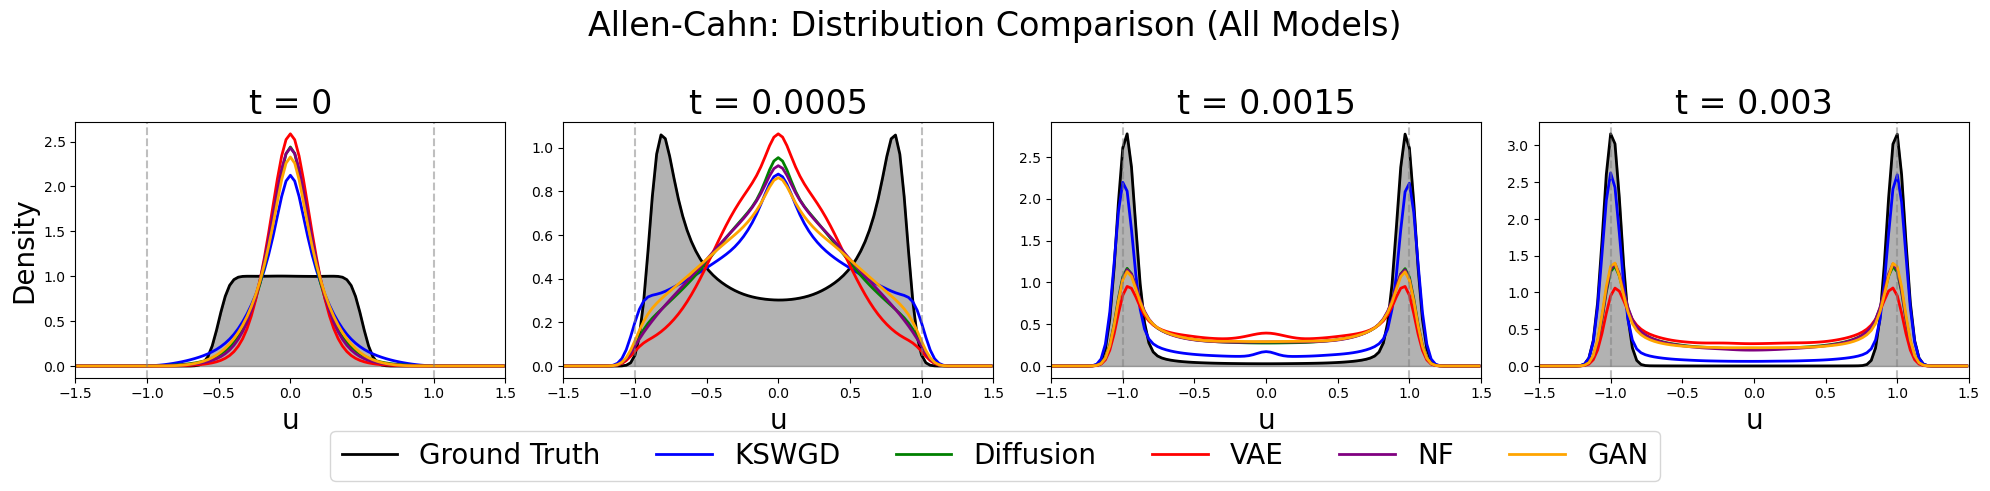

In [11]:
# === Distribution Comparison Figure (All Models) ===
from scipy.ndimage import gaussian_filter1d
from scipy.stats import wasserstein_distance

print("="*70)
print("FINAL COMPARISON: Distribution of All Generative Baselines")
print("="*70)

n_times = len(time_points)

# Create figure (no extra space on right needed now)
fig, axes2 = plt.subplots(1, n_times, figsize=(5*n_times, 5))

# Define colors and labels for legend
method_colors = {
    'Ground Truth': 'black',
    'KSWGD': 'blue',
    'Diffusion': 'green',
    'VAE': 'red',
    'NF': 'purple',
    'GAN': 'orange'
}

for col, t_phys in enumerate(time_points):
    kswgd_result = kswgd_time_results[t_phys]
    baseline_result = baseline_results[t_phys]

    gt_values = kswgd_result['ground_truth_samples'].flatten()
    kswgd_values = kswgd_result['predicted_samples'].flatten()
    diff_values = baseline_result['diffusion_samples'].flatten()
    vae_values = baseline_result['vae_samples'].flatten()
    flow_values = baseline_result['flow_samples'].flatten()
    gan_values = baseline_result['gan_samples'].flatten()

    ax = axes2[col]
    bins = np.linspace(-1.5, 1.5, 100)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    sigma = 2

    gt_hist, _ = np.histogram(gt_values, bins=bins, density=True)
    kswgd_hist, _ = np.histogram(kswgd_values, bins=bins, density=True)
    diff_hist, _ = np.histogram(diff_values, bins=bins, density=True)
    vae_hist, _ = np.histogram(vae_values, bins=bins, density=True)
    flow_hist, _ = np.histogram(flow_values, bins=bins, density=True)
    gan_hist, _ = np.histogram(gan_values, bins=bins, density=True)

    gt_smooth = gaussian_filter1d(gt_hist, sigma=sigma)
    kswgd_smooth = gaussian_filter1d(kswgd_hist, sigma=sigma)
    diff_smooth = gaussian_filter1d(diff_hist, sigma=sigma)
    vae_smooth = gaussian_filter1d(vae_hist, sigma=sigma)
    flow_smooth = gaussian_filter1d(flow_hist, sigma=sigma)
    gan_smooth = gaussian_filter1d(gan_hist, sigma=sigma)

    # Plot without individual legends
    ax.fill_between(bin_centers, gt_smooth, alpha=0.3, color='black')
    l1, = ax.plot(bin_centers, gt_smooth, color='black', linewidth=2)
    l2, = ax.plot(bin_centers, kswgd_smooth, color='blue', linewidth=2)
    l3, = ax.plot(bin_centers, diff_smooth, color='green', linewidth=2)
    l4, = ax.plot(bin_centers, vae_smooth, color='red', linewidth=2)
    l5, = ax.plot(bin_centers, flow_smooth, color='purple', linewidth=2)
    l6, = ax.plot(bin_centers, gan_smooth, color='orange', linewidth=2)
    
    ax.set_xlabel('u', fontsize=20)
    if col == 0:
        ax.set_ylabel('Density', fontsize=20)
    ax.set_title(f't = {t_phys}', fontsize=24)
    ax.set_xlim(-1.5, 1.5)
    ax.axvline(x=-1, color='gray', linestyle='--', alpha=0.5)
    ax.axvline(x=1, color='gray', linestyle='--', alpha=0.5)

# Create shared horizontal legend at the bottom
fig.legend([l1, l2, l3, l4, l5, l6], 
           ['Ground Truth', 'KSWGD', 'Diffusion', 'VAE', 'NF', 'GAN'],
           loc='lower center', 
           ncol=6,  # All items in one row
           fontsize=20,
           frameon=True,
           bbox_to_anchor=(0.5, 0.01))

plt.suptitle('Allen-Cahn: Distribution Comparison (All Models)', fontsize=24)
plt.tight_layout(rect=[0, 0.1, 1, 0.95])  # Leave space for legend at bottom
plt.show()

## Summary of Methods & Key Hyperparameters (Settings Only)

This section lists only the models/baselines used in this notebook and their key hyperparameter settings. No analysis or conclusions are included.

### Data generation: Stochastic Allen–Cahn (SPDE)
- Spatial grid: `N=128`
- Simulation time step: `dt_sim=1e-5`
- Interface width: `epsilon=0.02`
- Noise intensity: `SIGMA_NOISE=0.1`
- Time points: `time_points = [0, 0.0005, 0.0015, 0.003]`
- Independent samples per time point: `n_samples=150`

### Representation learning: Autoencoder (AE) latent space
- Latent dimension: `latent_dim=8`
- Training epochs: `n_epochs_ae=100`
- Optimizer: Adam, learning rate `lr=1e-3`
- Batch size: `batch_size=32`
- Scaling: physical fields are linearly scaled to `[-1, 1]` before learning/generation, then rescaled back to the original range

### Method 1: KSWGD + Koopman (EDMD) prediction (latent space)
- EDMD dictionary: polynomial features with bias, `poly_order=4`
- EDMD regularization: `reg_edmd=1e-4`
- KSWGD particles: `m_particles=100`
- KSWGD iterations: `num_iters_kswgd=500`
- KSWGD step size: `step_size_kswgd=0.05`
- Kernel bandwidth: `eps_kswgd = median(distance^2) / (2*log(n+1))`, clipped to `>= 1e-6`
- Eigenvalue threshold: `tol_kswgd=1e-6` (for selecting kernel eigenfunctions)
- Random seeds: `np.random.seed(1)`; KSWGD init uses `np.random.default_rng(1)`
- Device: KSWGD GPU backend enabled when available (auto-detected)

### Method 2: Diffusion (DDPM, latent space)
- Training epochs: `n_epochs=150`
- Diffusion steps: `n_timesteps=200`
- Beta schedule: `betas = linspace(1e-4, 0.02, n_timesteps)`
- Network: MLP (`hidden_dim=256`, time embedding `time_emb_dim=64`)
- Optimizer: Adam, learning rate `lr=1e-3`
- Generated samples per time point: `n_samples_gen=100`

### Method 3: VAE (latent space)
- Training epochs: `n_epochs=150`
- VAE inner latent dimension: `vae_latent_dim=4`
- MLP hidden dimension: `hidden_dim=128`
- KL weight: `beta=0.1`
- Optimizer: Adam, learning rate `lr=1e-3`
- Generated samples per time point: `n_samples_gen=100`

### Method 4: Normalizing Flow (RealNVP, latent space)
- Training epochs: `n_epochs=150`
- Coupling layers: `n_layers=4`
- MLP hidden dimension: `hidden_dim=128`
- Optimizer: Adam, learning rate `lr=1e-3`
- Generated samples per time point: `n_samples_gen=100`

### Method 5: GAN (WGAN-GP, latent space)
- Training epochs: `n_epochs=150`
- Noise dimension: `noise_dim=16`
- Generator/Critic MLP hidden dimension: `hidden_dim=256`
- Critic steps per generator step: `n_critic=5`
- Gradient penalty coefficient: `lambda_gp=10.0`
- Optimizer: Adam, learning rate `lr=1e-4`, `betas=(0.5, 0.9)`
- Generated samples per time point: `n_samples_gen=100`

### Shared visualization/statistics settings
- Histogram bins: `bins = linspace(-1.5, 1.5, 100)`
- Smoothing: `gaussian_filter1d` with `sigma=2`

## Brief Overview: How Each Baseline Models the Distribution

All baseline methods operate in the **shared AE latent space**. For each target time point, they are trained independently on the latent codes of ground-truth samples at that time, then used to generate new samples.

### Method 2: Diffusion (DDPM)
- **Training**: Learn a noise-conditioned denoiser $\epsilon_\theta(z_t, t)$ that predicts the noise added to a clean latent code $z_0$ at diffusion step $t$.
- **Sampling**: Start from pure Gaussian noise $z_T \sim \mathcal{N}(0, I)$ and iteratively denoise for $T$ steps using the learned denoiser, producing a sample $z_0$ from the target distribution.
- **Key idea**: Model the data distribution implicitly via a learned reverse diffusion process.

### Method 3: VAE (Variational Autoencoder)
- **Training**: Learn an encoder $q_\phi(w|z)$ that maps AE latent $z$ to a smaller latent $w$, and a decoder $p_\theta(z|w)$ that reconstructs $z$. Optimize the ELBO (reconstruction + KL regularization).
- **Sampling**: Draw $w \sim \mathcal{N}(0, I)$ from the prior, then decode to get a new latent $z = p_\theta(z|w)$.
- **Key idea**: Regularize the latent space to be Gaussian so that ancestral sampling is straightforward.

### Method 4: Normalizing Flow (RealNVP)
- **Training**: Learn an invertible mapping $f_\theta: z \leftrightarrow w$ between AE latent $z$ and a base Gaussian $w$. Maximize exact log-likelihood using the change-of-variables formula.
- **Sampling**: Draw $w \sim \mathcal{N}(0, I)$, then apply the inverse $z = f_\theta^{-1}(w)$ to get a sample from the target distribution.
- **Key idea**: Bijective transformations allow exact density evaluation and efficient sampling.

### Method 5: GAN (WGAN-GP)
- **Training**: Train a generator $G_\theta$ that maps noise $\xi \sim \mathcal{N}(0, I)$ to latent codes, and a critic $D_\psi$ that distinguishes real vs. generated latents. Use Wasserstein loss with gradient penalty.
- **Sampling**: Draw noise $\xi \sim \mathcal{N}(0, I)$, then output $z = G_\theta(\xi)$.
- **Key idea**: Adversarial training pushes the generator distribution toward the data distribution without explicit density estimation.

---
**Common workflow for all baselines**:
1. Encode ground-truth physical fields at target time $t$ into AE latent codes.
2. Normalize latent codes (zero mean, unit std) for stable training.
3. Train the generative model on normalized latents.
4. Generate new latent samples, denormalize, then decode back to physical space via the shared AE decoder.